In [319]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, datetime, math
from news_test import daily_sentiment

In [320]:
filename = 'JNJ.csv' #pick stock
ticker = filename.split('.')[0] #get ticker
df = pd.read_csv('./data_clean/' + filename, index_col=0, sep=',') #load in dataset – uploaded on git, originally downloaded from https://www.kaggle.com/jacksoncrow/stock-market-dataset
price_config = 'close' #use close to determine price

In [321]:
#turn index col (string) into date col

def date_parse(s): #date strings are in form '2015-01-01'
    d = s.split('-')
    return datetime.date(int(d[0]), int(d[1]), int(d[2]))

df.index = df.index.map(date_parse)

#training data comes from 2015–2018 prices, test data comes from 2019 prices
#ignore 2020 data, since we lack sentiment data for most of it
df = df[df.index < datetime.date(2020, 1, 1)]

In [322]:
#make running sentiment column based on index (date) col
df['sentiment'] = [daily_sentiment(ticker, d) for d in df.index.values]

In [323]:
#make 5-day volatility column for trading days after the first 5
df['weekly_volatility'] = np.nan
for i in range(len(df.index.values))[4:]: #[4, 5, ..., len(df.index.values)]
    df.at[df.index[i], 'weekly_volatility'] = df[price_config][i-4:i+1].std()
print(df['weekly_volatility'])

date
2015-01-02         NaN
2015-01-05         NaN
2015-01-06         NaN
2015-01-07         NaN
2015-01-08    1.272033
                ...   
2019-12-24    1.292720
2019-12-26    0.394675
2019-12-27    0.270870
2019-12-30    0.408472
2019-12-31    0.252346
Name: weekly_volatility, Length: 1258, dtype: float64


In [324]:
df #explore dataset structure

,open,high,low,close,adj close,volume,sentiment,weekly_volatility
date,,,,,,,,
2015-01-02,105.050003,105.550003,104.129997,104.519997,90.534592,5753600,0.010592,NaN
2015-01-05,104.480003,104.730003,103.680000,103.790001,89.902267,8079300,-0.001499,NaN
2015-01-06,104.339996,104.989998,102.940002,103.279999,89.460510,7428000,0.004436,NaN
2015-01-07,103.910004,105.830002,103.809998,105.559998,91.435432,7931700,0.010637,NaN
2015-01-08,106.059998,106.489998,105.750000,106.389999,92.154381,9916000,0.034384,1.272033
...,...,...,...,...,...,...,...,...
2019-12-24,146.000000,146.009995,145.259995,145.929993,145.005341,4238900,0.013606,1.292720
2019-12-26,145.970001,146.179993,145.160004,145.830002,144.905991,3019300,0.014540,0.394675
2019-12-27,146.199997,146.550003,145.539993,145.750000,144.826492,3432700,0.021141,0.270870


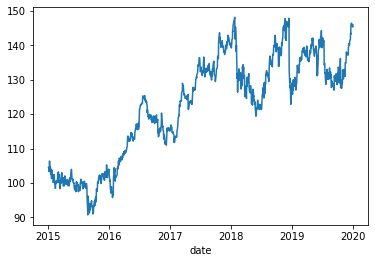

In [325]:
# Find local peaks
df['min'] = df.close[(df.close.shift(1) > df.close) & (df.close.shift(-1) > df.close)]
df['max'] = df.close[(df.close.shift(1) < df.close) & (df.close.shift(-1) < df.close)]

#show closing price changes over time
df.close.plot()

In [326]:
#set some default variables
bank = 100000 #set initial investor capital
portfolio = {ticker: 0} #initialize empty portfolio
num_contracts = 1 #trade one contract at a time

In [327]:
#get categorical columns for closing price, trading volume, and sentiment

def price_categorize(col): #start with price. don't replace price values with categories because they're needed to calculate reward/profit
    
    new_col = np.empty(len(col), dtype="<U4")
    for i in range(len(col)):
        if i == 0 or col[i] == col[i-1]:
            new_col[i] = 'same'
            
        elif col[i] < col[i-1]:
            new_col[i] = 'down'
            
        else:
            new_col[i] = 'up'
            
    return new_col

price_movements = price_categorize(df[price_config])


#get categorical volume column
quantiles = (df.volume.quantile(1/3), df.volume.quantile(2/3))

tri = [0] * len(df) #3 quantile separator

for i in range(len(df['volume'])): #replace volume counts with categories
    if df['volume'][i] <= quantiles[0]:
        tri[i] = 'low'
    elif df['volume'][i] <= quantiles[1]:
        tri[i] = 'med'
    else:
        tri[i] = 'high'

df = df.assign(volume=tri)



#get categorical sentiment column

quantiles = (df.sentiment.quantile(1/3), df.sentiment.quantile(2/3))
tri2 = [0] * len(df)

for i in range(len(df['sentiment'])): #replace volume counts with categories
    if df['sentiment'][i] <= quantiles[0]:
        tri2[i] = 'neg' #negative
    elif df['sentiment'][i] <= quantiles[1]:
        tri2[i] = 'neut' #neutral
    else:
        tri2[i] = 'pos' #positive

df = df.assign(sentiment=tri2)

In [328]:
#get new portfolio and transaction cost/profit for a buy or a sell with given parameters
#trade one contract at a time by default

def buy(stock_df, portfolio, date, capital, num_contracts=1): 
    
    transaction_cost = stock_df.at[date, price_config] * (num_contracts * 100)
    
    if capital < transaction_cost:
        return False #can't buy if you lack the funds
    
    current_holdings = portfolio[ticker]
        
    return {ticker: current_holdings+num_contracts}, -transaction_cost #approve transaction, return updated one-stock portfolio and profit/loss (-1 * transaction_cost)
    
    
def sell(stock_df, portfolio, date, num_contracts=1):  #capital is irrelevant for selling (you can sell with any amount of capital, as long as you have enough shares)
    
    if not portfolio[ticker] or num_contracts > portfolio[ticker]:
        return False #can't sell shares you don't own
    
    gain = stock_df.at[date, price_config] * (num_contracts * 100) 
    
    current_holdings = portfolio[ticker]
    
    return {ticker: current_holdings-num_contracts}, gain #approve transaction, return updated one-stock portfolio and gain

In [329]:
'''#get maximum profit available (profit from completely optimal trades over the trading period)

def max_profit(df, ticker, capital, num_contracts=1):
    portfolio = {ticker: 0} #portfolio initially consists of no shares
    extrema = df.dropna(thresh=len(df.columns)-1) #drop row if min and max both nan #how='all', subset=['min', 'max'])

    for trading_day in extrema.index.values[:-1]:
        
        b = buy(extrema, portfolio, trading_day, capital)
        s = sell(extrema, portfolio, trading_day)
        
        if b and not pd.isnull(extrema.at[trading_day, 'min']): #not nan on min col: it's a local min, and we buy
            portfolio = b[0]
            capital += b[1]
                
        elif s and not pd.isnull(extrema.at[trading_day, 'max']): #not nan on max col: it's a local max, and we sell
            portfolio = s[0]
            capital += s[1]
            
    final_portfolio_val = capital + portfolio[ticker] * 100 * df.at[df.index.values[-1], price_config]
            
    return final_portfolio_val, portfolio

mx_prof = max_profit(test_set, ticker, 100000) #get max portfolio value from 2019 trades, assuming Jan 1 start and Dec 31 end
print('max final 2019 portfolio value:', mx_prof[0], '\nshares held:', mx_prof[1])'''

"#get maximum profit available (profit from completely optimal trades over the trading period)\n\ndef max_profit(df, ticker, capital, num_contracts=1):\n    portfolio = {ticker: 0} #portfolio initially consists of no shares\n    extrema = df.dropna(thresh=len(df.columns)-1) #drop row if min and max both nan #how='all', subset=['min', 'max'])\n\n    for trading_day in extrema.index.values[:-1]:\n        \n        b = buy(extrema, portfolio, trading_day, capital)\n        s = sell(extrema, portfolio, trading_day)\n        \n        if b and not pd.isnull(extrema.at[trading_day, 'min']): #not nan on min col: it's a local min, and we buy\n            portfolio = b[0]\n            capital += b[1]\n                \n        elif s and not pd.isnull(extrema.at[trading_day, 'max']): #not nan on max col: it's a local max, and we sell\n            portfolio = s[0]\n            capital += s[1]\n            \n    final_portfolio_val = capital + portfolio[ticker] * 100 * df.at[df.index.values[-1], 

In [330]:
#create indices for q matrix: categorical state tuples in the form (trend, volume, sentiment)

import itertools

trend_features = ('up', 'down', 'same')
vol_features = ('low', 'med', 'high')
sent_features = ('neg', 'neut', 'pos')

state_features = ( trend_features, vol_features, sent_features ) #can be expanded further with more features!
states = list(itertools.product(*state_features))

print(states) #all combinations of one element from each state feature tuple

[('up', 'low', 'neg'), ('up', 'low', 'neut'), ('up', 'low', 'pos'), ('up', 'med', 'neg'), ('up', 'med', 'neut'), ('up', 'med', 'pos'), ('up', 'high', 'neg'), ('up', 'high', 'neut'), ('up', 'high', 'pos'), ('down', 'low', 'neg'), ('down', 'low', 'neut'), ('down', 'low', 'pos'), ('down', 'med', 'neg'), ('down', 'med', 'neut'), ('down', 'med', 'pos'), ('down', 'high', 'neg'), ('down', 'high', 'neut'), ('down', 'high', 'pos'), ('same', 'low', 'neg'), ('same', 'low', 'neut'), ('same', 'low', 'pos'), ('same', 'med', 'neg'), ('same', 'med', 'neut'), ('same', 'med', 'pos'), ('same', 'high', 'neg'), ('same', 'high', 'neut'), ('same', 'high', 'pos')]


In [331]:
import random
def arg_max(row): #pandas idxmax returns the first index of the max value in case of a tie; we want a random index instead
    maxes = row[row == row.max()]
    return random.choice(maxes.index)
    

actions = ('buy', 'sell', 'hold') #tuple of actions

num_portfolios = 1 #set number of portfolios we are creating

def q_learn(df, ticker, bank, risk_tolerance, alpha, decay_rate, gamma):
    
    #initialize q matrix, v (volatility) matrix, and c (state count – for calculating average state volatility) matrix
    q = pd.DataFrame(0.0, columns=actions, index=pd.MultiIndex.from_tuples(states))
    v = pd.DataFrame(0.0, columns=actions, index=pd.MultiIndex.from_tuples(states))
    c = pd.DataFrame(0.0, columns=actions, index=pd.MultiIndex.from_tuples(states))
    
    portfolio = {ticker: 0}
    i = 0
    
    initial_trend = price_movements[i]
    initial_vol = df.at[df.index[i], 'volume']
    initial_sent = df.at[df.index[i], 'sentiment']
    initial_state = (initial_trend, initial_vol, initial_sent)

    for pf in range(num_portfolios): #iterate through the number of portfolios you're processing
        
        s = initial_state
        
        while bank > 0 and i < len(df)-1: #stop on the day before the last (we use the next day's profit/loss to get the reward):
            
            e = decay_rate ** i #decayed-epsilon-greedy method
            
            current_date = df.index[i]
            current_price = df.at[current_date, price_config]
            next_date = df.index[i+1]
            next_price = df.at[next_date, price_config]
            
            #list out what actions you can take (can you buy and/or sell?)
            possible_actions = ['hold']
            
            long = buy(df, portfolio, current_date, bank) #long position
            if long: #transaction succeeds!
                possible_actions.append('buy')
                
            short = sell(df, portfolio, current_date)
            if short: #transaction succeeds!
                possible_actions.append('sell')
            
            
            #factor in epsilon
            if random.random() < e:
                a = random.choice(possible_actions) #set action
            
            else:
                a = arg_max(q.loc[s][possible_actions])
                
                
            if a == 'buy':
                portfolio[ticker] += num_contracts #update number of shares held
                bank += long[1] #update account
                reward = (next_price - current_price) * num_contracts * 100 #reward should be profit from next day. if you buy and the price went up, you get a positive reward
            
            if a == 'hold':
                reward = -risk_tolerance #user-specified penalty on holding
            
            if a == 'sell':    
                portfolio[ticker] -= num_contracts #update number of shares held
                bank += short[1] #update account
                reward = (current_price - next_price) * num_contracts * 100 #reward should be profit from next day. if you sell and the price goes down, you get a positive reward
            
            
            if not pd.isnull(df.at[current_date, 'weekly_volatility']): #don't count first week (no weekly volatility values available)
                v.at[s, a] += df.at[current_date, 'weekly_volatility']
                c.at[s, a] += 1
            
            #update state parameters
            trend = price_movements[i+1]
            vol = df.at[next_date, 'volume']
            sent = df.at[next_date, 'sentiment']
            
            
            #list out what actions you can take on the next trading day
            
            possible_actions = ['hold']
            
            long = buy(df, portfolio, next_date, bank) #long position
            if long: #transaction succeeds!
                possible_actions.append('buy')
                
            short = sell(df, portfolio, next_date)
            if short: #transaction succeeds!
                possible_actions.append('sell')
            
            s_next = (trend, vol, sent)
            q_next = q.at[s_next, arg_max(q.loc[s_next][possible_actions])]
            q_inc = alpha * ( reward + gamma * q_next - q.at[s, a])
            q.at[s, a] += q_inc
            
            s = s_next
            i += 1
            
    #print('q', q)
    
    
    #weight q values by average volatility: raise by a factor of (100 – |risk_level - v| )%
    avg_volatility = (v/c).fillna(0) #get average volatility matrix: total value matrix / count matrix. fill nan values (c = 0) with zeroes
    avg_volatility *= (100 / avg_volatility.values.max()) #normalize avg_volatility matrix and multiply by 100 to get a percentage (same scale as risk level)
    q_weight = (1 - abs(risk_tolerance - avg_volatility) / 100) #get factors to raise q by for each state
    q *= (1 + q_weight) #raise q by each factor
    
    #make sure that zero-count state/action combinations are never picked from the q matrix (could be selected randomly from the arg_max in q_test)
    for row in range(len(c.index)):
        for col in range(len(c.columns)):
            if c.iat[row, col] == 0:
                q.iat[row, col] = -math.inf
    
    #print('q weight', q_weight)
    
    bank += next_price * portfolio[ticker] * 100
    #print( {'risk level': risk_tolerance, 'alpha': alpha, 'balance': bank } )
    
    return bank, portfolio, q
                    

In [332]:
test_trends = price_movements[len(training_set):] #get trends for test set
max_bal = -1

def q_test(test_data, ticker, bank, q):
    
    #initialize
    portfolio = {ticker: 0}
    i = 0
    
    global max_bal
    
    initial_trend = test_trends[i]
    initial_vol = test_data.at[test_set.index[i], 'volume']
    initial_sent = test_data.at[test_set.index[i], 'sentiment']
    initial_state = (initial_trend, initial_vol, initial_sent)
    
    action_list = []
    
    for pf in range(num_portfolios): #iterate through the number of portfolios you're processing (set to 1)
        
        s = initial_state
        
        #for testing

        while bank > 0 and i < len(test_data)-1: #stop on the day before the last (we use the next day's profit/loss to get the reward):
            
            current_date = test_data.index[i]
            current_price = test_data.at[current_date, price_config]
            next_date = test_data.index[i+1]
            next_price = test_data.at[next_date, price_config]
            
            #list out what actions you can take (can you buy and/or sell?)
            possible_actions = ['hold']
            
            long = buy(test_data, portfolio, current_date, bank) #long position
            if long: #transaction succeeds!
                possible_actions.append('buy')
                
            short = sell(test_data, portfolio, current_date)
            if short: #transaction succeeds!
                possible_actions.append('sell')
                 
            a = arg_max(q.loc[s][possible_actions])
                
            if a == 'buy':
                portfolio[ticker] += num_contracts #update number of shares held
                bank += long[1] #update account
                
            if a == 'sell':    
                portfolio[ticker] -= num_contracts #update number of shares held
                bank += short[1] #update account
            
            trend = price_movements[i+1]
            vol = df.at[next_date, 'volume']
            sent = df.at[next_date, 'sentiment']
            s = (trend, vol, sent) #get next state
            
            i += 1
            
            if bank + portfolio[ticker] * next_price * 100 > max_bal:
                max_bal = bank + portfolio[ticker] * next_price * 100
    
    bank += next_price * portfolio[ticker] * 100 #calculate final portfolo value
    
    return bank, portfolio
                    

In [333]:
#cross-validation

#helper for s_fold: creates the folds
def s_partition(s, data): 
    
    fold_size = math.ceil( len(data) / s ) #take the ceiling so no elements are missed in the case of an uneven split
    
    folded_data = [] #store folds in a list
    
    i = 0
    while i < len(data):
        
        #append the folds, incrementing by the size of each fold
        folded_data.append(data[i:i+fold_size]) 
        
        i += fold_size
        
    return folded_data

#q_learn(df, ticker, bank, risk_tolerance, alpha=0.01, e=1, y=1):
#return bank, portfolio, q

def s_fold(folds, data, model, model_args):
    
    folded_data = s_partition(folds, data)
    q = pd.DataFrame(0.0, columns=actions, index=pd.MultiIndex.from_tuples(states))
    
    for data_fold_index in range(folds):
        
        #exclude current fold, use other folds as training data
        training_data = folded_data[:data_fold_index] + folded_data[data_fold_index+1:] #3d array: each element is a 2d data fold
        training_data = pd.concat(training_data) #combine the 3d array into one single 2d data array to use as the feature input
        
        learner = model(training_data, **model_args) #fit model to other partitions
        
        q += learner[2]
        
    q /= folds #get "average" q values    
    return q

In [334]:
#set training and test data
training_set = df[df.index < datetime.date(2019, 1, 1)]
test_set = df[df.index >= datetime.date(2019, 1, 1)] 

#hyperparameter tuning

learning_rates = (0.001, 0.01, 0.1)
risk_levels = (0, 25, 50, 75, 100)
decay_rates = (0.9, 0.99, 0.999)
gammas = (0.0, 0.25, 0.5, 0.75, 1)

#total runs = 3 * 5 * 3 * 5 = 225

k = 5

#initialize empty dictionaries of profit values for each hyperparameter. these will be averaged to find the optimal parameters
learning_profits, risk_profits, decay_profits, gamma_profits = dict.fromkeys(learning_rates, 0), dict.fromkeys(risk_levels, 0), dict.fromkeys(decay_rates, 0), dict.fromkeys(gammas, 0)

runs = []

for learning_rate in learning_rates:
    for gamma in gammas:
        for epsilon in decay_rates:
            for risk_level in risk_levels: #test risk levels in increments of 10
                

                cross_q = s_fold(k, training_set, q_learn, {'ticker': ticker, 'bank': bank, 
                        'risk_tolerance': risk_level, 'alpha': learning_rate, 'decay_rate': epsilon, 'gamma': gamma})
                bal = q_test(test_set, ticker, bank, cross_q)[0]

                if bal == max_bal:
                    best_params = {'balance': bal, 'risk level': risk_level, 'alpha': learning_rate,
                                'epsilon': epsilon, 'gamma': gamma} #best params here is the set that yields the highest final balance
                    
                risk_profits[risk_level] += bal
                decay_profits[epsilon] += bal
                gamma_profits[gamma] += bal
                learning_profits[learning_rate] += bal
                    
                run = {'portfolio value': bal, 'risk level': risk_level, 'alpha': learning_rate,
                                  'epsilon': epsilon, 'gamma': gamma}
                
                print(run)
                
                runs.append(run)
                
print ('maximum possible final portfolio value: ' + str(max_bal), best_params) #print final portfolio value from best run


{'portfolio value': 105609.99984741211, 'risk level': 0, 'alpha': 0.001, 'epsilon': 0.9, 'gamma': 0.0}
{'portfolio value': 111318.99490356444, 'risk level': 25, 'alpha': 0.001, 'epsilon': 0.9, 'gamma': 0.0}
{'portfolio value': 116349.00207519528, 'risk level': 50, 'alpha': 0.001, 'epsilon': 0.9, 'gamma': 0.0}
{'portfolio value': 107252.00500488281, 'risk level': 75, 'alpha': 0.001, 'epsilon': 0.9, 'gamma': 0.0}
{'portfolio value': 111436.00463867183, 'risk level': 100, 'alpha': 0.001, 'epsilon': 0.9, 'gamma': 0.0}
{'portfolio value': 108022.99499511719, 'risk level': 0, 'alpha': 0.001, 'epsilon': 0.99, 'gamma': 0.0}
{'portfolio value': 107580.99975585936, 'risk level': 25, 'alpha': 0.001, 'epsilon': 0.99, 'gamma': 0.0}
{'portfolio value': 109955.00640869139, 'risk level': 50, 'alpha': 0.001, 'epsilon': 0.99, 'gamma': 0.0}
{'portfolio value': 102841.00875854491, 'risk level': 75, 'alpha': 0.001, 'epsilon': 0.99, 'gamma': 0.0}
{'portfolio value': 103362.00256347655, 'risk level': 100, 'a

{'portfolio value': 106865.00396728514, 'risk level': 100, 'alpha': 0.01, 'epsilon': 0.9, 'gamma': 0.0}
{'portfolio value': 99467.00134277344, 'risk level': 0, 'alpha': 0.01, 'epsilon': 0.99, 'gamma': 0.0}
{'portfolio value': 106989.00146484374, 'risk level': 25, 'alpha': 0.01, 'epsilon': 0.99, 'gamma': 0.0}
{'portfolio value': 106875.00610351561, 'risk level': 50, 'alpha': 0.01, 'epsilon': 0.99, 'gamma': 0.0}
{'portfolio value': 106552.0004272461, 'risk level': 75, 'alpha': 0.01, 'epsilon': 0.99, 'gamma': 0.0}
{'portfolio value': 105658.99963378905, 'risk level': 100, 'alpha': 0.01, 'epsilon': 0.99, 'gamma': 0.0}
{'portfolio value': 108668.99719238278, 'risk level': 0, 'alpha': 0.01, 'epsilon': 0.999, 'gamma': 0.0}
{'portfolio value': 110441.00036621088, 'risk level': 25, 'alpha': 0.01, 'epsilon': 0.999, 'gamma': 0.0}
{'portfolio value': 103112.9928588867, 'risk level': 50, 'alpha': 0.01, 'epsilon': 0.999, 'gamma': 0.0}
{'portfolio value': 106414.99633789058, 'risk level': 75, 'alpha'

KeyboardInterrupt: 

In [ ]:
#use average final balance for each hyperparameter to determine its optimal value (using a more detailed metric)


#get average final balance value
def avg_run(param_dict, total_runs):
    ret = dict(param_dict)
    for param in ret.keys():
        ret[param] /= (total_runs / len(ret.keys() ) ) #divide total of all balances associated with each hyperparameter by the number of runs made with it
    return ret

total_runs = len(learning_profits.keys()) * len(risk_profits.keys()) * len(decay_profits.keys()) * len(gamma_profits.keys())
learning_profits, risk_profits, decay_profits, gamma_profits = avg_run(learning_profits, total_runs), avg_run(risk_profits, total_runs), avg_run(decay_profits, total_runs), avg_run(gamma_profits, total_runs)

print(learning_profits, risk_profits, decay_profits, gamma_profits)


def get_max_val(profit_dict): #get best_param from one of the profit dictionaries
    max_val, best_param = -1, -1
    for k,v in profit_dict.items():
        if v > max_val:
            max_val = v
            best_param = k
    return best_param

best_params = {'alpha': get_max_val(learning_profits), 'risk level': get_max_val(risk_profits),
                                  'epsilon': get_max_val(decay_profits), 'gamma': get_max_val(gamma_profits)}
print(best_params)
            

So the best learning rate is 0.001, the best risk level is 25, the best value at which to begin the decay is 0.99, and the best discount factor is 0. These can change in succeeding cross-validation trials due to the randomness imposed by epsilon. However, this set proved to perform the best under many repeated runs.

Optimal hyperparameters may also vary for different stocks, but for the sake of saving time, these default hyperparameters are used for the test below.

In [352]:
#test with default hyperparameters
#run 10 repeated tests to build out a confidence interval for the (population) proportion of the maximum profit captured by the test run

k = 5
best_params = {'alpha': 0.001, 'risk level': 25, 'epsilon': 0.99, 'gamma': 0}

percents = np.empty((0,0))

for trial in range(10):
    q = s_fold(k, training_set, q_learn, {'ticker': ticker, 'bank': bank, 'risk_tolerance': best_params['risk level'], 
            'alpha': best_params['alpha'], 'decay_rate': best_params['epsilon'], 'gamma': best_params['gamma']})
    test_run = q_test(test_set, ticker, bank, q)
    
    profit_captured = (test_run[0] % bank / (max_bal % bank))
    
    percents = np.append(percents, profit_captured)

    #output = {'balance': test_run[0], 'risk level': best_params['risk level'], 'alpha': best_params['alpha'],
    #                              'epsilon': best_params['epsilon'], 'gamma': best_params['gamma']}
    
#print(test_run)



In [353]:
#build out CI
lower_bound = round(np.mean(percents) - 1.96 * np.std(percents), 2)
upper_bound = round(np.mean(percents) + 1.96 * np.std(percents), 2)
print('CI:', '[' + str(lower_bound) + ',', str(upper_bound) + ']')

CI: [0.24, 0.88]


There is a wide variance between the lower and upper bounds because the model is overfitting to the training data (2015–2018). The 2019 price, volume, and sentiment movement patterns for this stock may be very different from those of 2015–2018.